### 导包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, recall_score, f1_score, precision_score

#import eli5
#from eli5.sklearn import PermutationImportance
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 图片输出为矢量图，保证清晰度

### 导入数据、归一化、划分训练集测试集

In [2]:
data=pd.read_csv('./clean-data.csv')
data=data.drop(['Unnamed: 0'],axis=1)
X=data.drop(['Group'],axis=1)
y=data['Group']

In [3]:
column=X.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(data=X,columns=column)

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=None)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (132, 203)
Test shape: (33, 203)


### 交叉验证函数

In [4]:
def crosspredict(estimator,Xtrain,ytrain,cv):
    print("cross-validate across the entire data set")
    y_pred_cross=cross_val_predict(estimator,Xtrain,ytrain,cv=cv)
    confusion_cross=confusion_matrix(ytrain,y_pred_cross)
    a=accuracy_score(ytrain,y_pred_cross)
    p=precision_score(ytrain, y_pred_cross)
    r=recall_score(ytrain, y_pred_cross)
    f1=f1_score(ytrain, y_pred_cross)
    wf1=f1_score(ytrain, y_pred_cross, average='weighted')
    #auc=roc_auc_score(ytrain,estimator.predict_proba(Xtrain)[:,1])
    print('the confusion_matrix of the model is : \n',confusion_cross)
    print('the accuracy of the model is : ',a)
    print("the precision score of the model is : ", p)
    print("the recall score of the model is :", r)
    print('the f1_score of the model  is :',f1)
    print('the weighted_f1 of the model is :',wf1)
    print('the classification_report is :\n',classification_report(ytrain, y_pred_cross,digits=4))
    #print('the auc is :',auc)
    return a,p,r,f1,wf1

### 集成模型

In [5]:
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin, BaseEstimator
class MyEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model, mask) -> None:
        super().__init__()
        self.mask = mask
        self.model = model
    
    def fit(self, X, y=None):
        self.model.fit(X[self.mask],y)
        return self

    def predict(self, X):
        return self.model.predict(X[self.mask])
    
    def predict_proba(Xtrain):
        return self.model.predict_proba(Xtrain)[:,1]
        

In [6]:
from itertools import *
sel_seq_dt_mask=['APG_0101010010M','APG_0101010055P','APG_0101010063M','APG_0101010341M','APG_0101010354P']
sel_seq_rf_mask=['APG_0101010055P','APG_0101010262P','APG_0101010266P']
sel_seq_ada_mask=['APG_0101010033M','APG_0101010063M','APG_0101010067M','APG_0101010147M','APG_0101010192M', 'APG_0101010236M']
sel_seq_gb_mask=['APG_0101010002M','APG_0101010055P','APG_0101010266P','APG_0101010354P']
sel_seq_xgb_mask=['APG_0101010010M','APG_0101010037P','APG_0101010063M','APG_0101010078P','APG_0101010150P','APG_0101010230P','APG_0101010279P','APG_0101010312P','APG_0101020013M']
sel_seq_gnb_mask=['APG_0101010010M','APG_0101010055P','APG_0101010057M','APG_0101010081M','APG_0101010085P','APG_0101010199P','APG_0101010264P','APG_0101010279P', 'APG_0101010300P']
feature=list(set(sel_seq_dt_mask+sel_seq_rf_mask+sel_seq_ada_mask+sel_seq_gnb_mask+sel_seq_xgb_mask))
model_dt_fs = MyEstimator(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=6), sel_seq_dt_mask)
model_rf_fs = MyEstimator(RandomForestClassifier(max_depth=8, n_estimators=105, n_jobs=-1,random_state=90), sel_seq_rf_mask)
model_ada_fs = MyEstimator(AdaBoostClassifier(learning_rate=0.1), sel_seq_ada_mask)
model_gb_fs = MyEstimator(GradientBoostingClassifier(loss='exponential', n_estimators=300), sel_seq_gb_mask)
model_xgb_fs = MyEstimator(XGBClassifier(booster='gblinear',learning_rate=0.3,n_estimators=10), mask=sel_seq_xgb_mask)
model_gnb_fs=MyEstimator(GaussianNB(),mask=sel_seq_gnb_mask)
from sklearn.ensemble import VotingClassifier
model_voting= VotingClassifier([
    ("dt",model_dt_fs),
    ("rf",model_rf_fs),
    ("ada", model_ada_fs),
    ("xgb", model_xgb_fs),
    ("gnb",model_gnb_fs),
], voting="hard")
#a,b,c,d,e=crosspredict(model_voting,X,y,10)

### PermutationImportance

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

In [16]:
my_model=model_voting.fit(X_train,y_train)
perm=PermutationImportance(my_model,random_state=3).fit(X_test,y_test)
eli5.show_weights(perm,feature_names=X_test.columns.tolist())

Weight,Feature
0.1333 ± 0.1057,APG_0101010055P
0.0727 ± 0.0485,APG_0101010010M
0.0667 ± 0.0891,APG_0101010192M
0.0424 ± 0.0297,APG_0101010033M
0.0303 ± 0.0383,APG_0101010300P
0.0242 ± 0.0594,APG_0101010262P
0.0242 ± 0.0707,APG_0101010063M
0.0182 ± 0.0822,APG_0101010150P
0.0121 ± 0.1124,APG_0101010266P
0.0061 ± 0.0454,APG_0101010279P


### 部分依赖图

In [7]:
from pdpbox import pdp,get_dataset,info_plots

In [8]:
my_model=model_voting.fit(X_train,y_train)

In [9]:
feature_names=X.columns

In [12]:
help(pdp.pdp_plot)

Help on function pdp_plot in module pdpbox.pdp:

pdp_plot(pdp_isolate_out, feature_name, center=True, plot_pts_dist=False, plot_lines=False, frac_to_plot=1, cluster=False, n_cluster_centers=None, cluster_method='accurate', x_quantile=False, show_percentile=False, figsize=None, ncols=2, plot_params=None, which_classes=None)
    Plot partial dependent plot
    
    Parameters
    ----------
    
    pdp_isolate_out: (list of) instance of PDPIsolate
        for multi-class, it is a list
    feature_name: string
        name of the feature, not necessary a column name
    center: bool, default=True
        whether to center the plot
    plot_pts_dist: bool, default=False
        whether to show data points distribution
    plot_lines: bool, default=False
        whether to plot out the individual lines
    frac_to_plot: float or integer, default=1
        how many lines to plot, can be a integer or a float
    cluster: bool, default=False
        whether to cluster the individual lines and

In [13]:
 plot_params = {
                # plot title and subtitle
                'title': 'PDP for feature "%s"' % feature_name,
                'subtitle': "Number of unique grid points: %d" % n_grids,
                'title_fontsize': 15,
                'subtitle_fontsize': 12,
                'font_family': 'Arial',
                # matplotlib color map for ICE lines
                'line_cmap': 'Blues',
                'xticks_rotation': 0,
                # pdp line color, highlight color and line width
                'pdp_color': '#1A4E5D',
                'pdp_hl_color': '#FEDC00',
                'pdp_linewidth': 1.5,
                # horizon zero line color and with
                'zero_color': '#E75438',
                'zero_linewidth': 1,
                # pdp std fill color and alpha
                'fill_color': '#66C2D7',
                'fill_alpha': 0.2,
                # marker size for pdp line
                'markersize': 3.5,
            }

NameError: name 'feature_name' is not defined

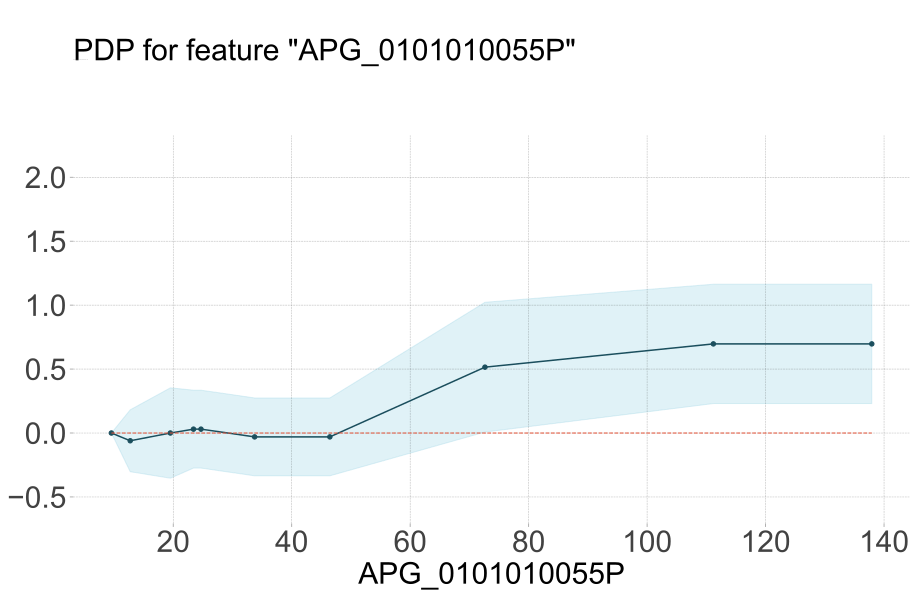

In [10]:
feature_to_plot='APG_0101010055P'
pdp_list=pdp.pdp_isolate(model=my_model,dataset=X_test,model_features=feature_names,feature=feature_to_plot)
pdp.pdp_plot(pdp_list,feature_to_plot,plot_params={
    'title_fontsize':30,
    'subtitle_fontsize':0,
    'markersize':4.5,
    
})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(feature_to_plot,fontsize=30)
plt.savefig('E:/lung_cancer_prediction/images/Private data set/PDP_APG_01_0101010055P.png', dpi=500, bbox_inches='tight') 
plt.show()

### 拼接部分依赖图

In [38]:
from PIL import Image
import glob

# 获取所有需要拼接的图像路径
path = 'E:/lung_cancer_prediction/images/Private data set'  # 图片所在的目录路径
image_paths = glob.glob(path + '/PDP_APG*.png')
rows=4
cols=2

# 读入第一张图像作为基准
base_image = Image.open(image_paths[0])

# 获取基准图像的尺寸
w,h = 6400,4200

# 创建空白图像
result = Image.new('RGB', (w*cols,h*rows),color='white')

# 将所有图像拼接在一起
for i in range(rows):
    for j in range(cols):
        index = i*cols+j
        if index < len(image_paths):
            image = Image.open(image_paths[index])
            result.paste(image, (j*w, i*h))


# 显示结果
result.save('E:/lung_cancer_prediction/images/Private data set/PDP_change2.jpg')
#result.show()

### 部分依赖交互图

In [12]:
help(pdp.pdp_interact_plot)

Help on function pdp_interact_plot in module pdpbox.pdp:

pdp_interact_plot(pdp_interact_out, feature_names, plot_type='contour', x_quantile=False, plot_pdp=False, which_classes=None, figsize=None, ncols=2, plot_params=None)
    PDP interact
    
    Parameters
    ----------
    
    pdp_interact_out: (list of) instance of PDPInteract
        for multi-class, it is a list
    feature_names: list
        [feature_name1, feature_name2]
    plot_type: str, optional, default='contour'
        type of the interact plot, can be 'contour' or 'grid'
    x_quantile: bool, default=False
        whether to construct x axis ticks using quantiles
    plot_pdp: bool, default=False
        whether to plot pdp for each feature
    which_classes: list, optional, default=None
        which classes to plot, only use when it is a multi-class problem
    figsize: tuple or None, optional, default=None
        size of the figure, (width, height)
    ncols: integer, optional, default=2
        number subplot

In [10]:
plot_params = {
                # plot title and subtitle
                'title': 'PDP interact for "%s" and "%s"',
                'subtitle': 'Number of unique grid points: (%s: %d, %s: %d)',
                'title_fontsize': 15,
                'subtitle_fontsize': 12,
                # color for contour line
                'contour_color':  'white',
                'font_family': 'Arial',
                # matplotlib color map for interact plot
                'cmap': 'viridis',
                # fill alpha for interact plot
                'inter_fill_alpha': 0.8,
                # fontsize for interact plot text
                'inter_fontsize': 9,
            }

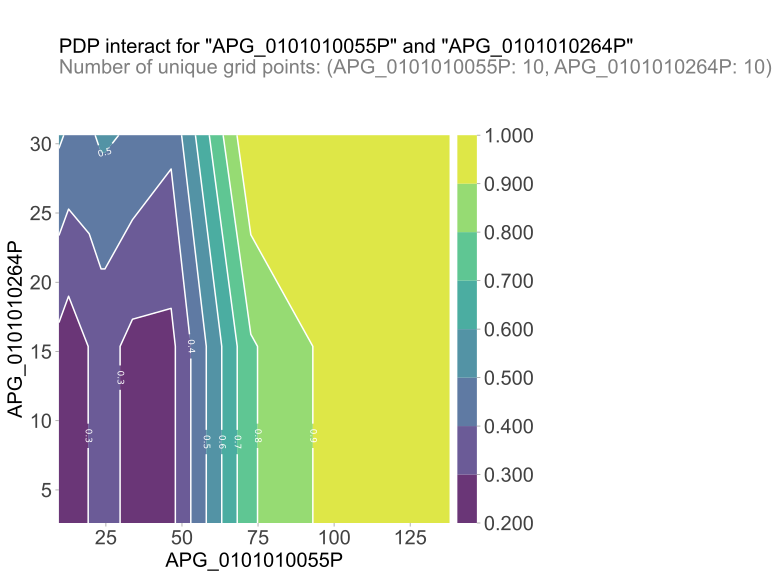

In [11]:
features_to_plot=['APG_0101010055P','APG_0101010264P']
inter1=pdp.pdp_interact(model=my_model,dataset=X_test,model_features=feature_names,features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1,feature_names=features_to_plot,
plot_params={
#     'title_fontsize':20,
#     'subtitle_fontsize':0,
    'contour_color':  'white',
    'inter_fontsize':9,

})
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.xlabel('APG_0101010192M',fontsize=25)
# plt.ylabel('APG_0101010078P',fontsize=25)

plt.savefig('E:/lung_cancer_prediction/images/Private data set/PDP_change_05_55_264.png', dpi=500, bbox_inches='tight') 
plt.show()

### 拼接部分依赖交互图

In [16]:
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
import glob

# 获取所有需要拼接的图像路径
path = 'E:/lung_cancer_prediction/images/Private data set'  # 图片所在的目录路径
image_paths = glob.glob(path + '/PDP_change*.png')

rows=2
cols=2

# 读入第一张图像作为基准
base_image = Image.open(image_paths[0])

# 获取基准图像的尺寸
w,h = 4600,4100

passw=w/2
passh=4000

# 创建空白图像
result = Image.new('RGB', (w*cols,h*rows),color='white')
t=1
text='(%d)'%(t)
draw = ImageDraw.Draw(result)
font_size = 100  
font = ImageFont.truetype('arial.ttf',font_size)
# 将所有图像拼接在一起
for i in range(rows):
    for j in range(cols):
        index = i*cols+j
        if index < len(image_paths):
            image = Image.open(image_paths[index])
            result.paste(image, (j*w, i*h))
            x=j*w+passw
            y=i*h+passh
            text='(%d)'%(t)
            draw.text((x,y),text,fill=(0,0,0),font=font)
            t=t+1


# 显示结果
result.save('E:/lung_cancer_prediction/images/Private data set/PDP_interact_5.jpg')
# result.show()